In [107]:
#IMPORTING LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
#Loading Data
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv')
all_df = pd.concat([train_df,test_df], ignore_index=True)
all_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [109]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


<AxesSubplot:ylabel='Survived'>

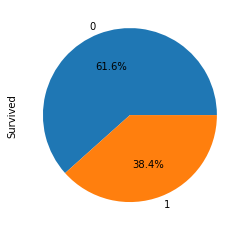

In [110]:
train_df['Survived'].value_counts().plot.pie(autopct='%1.1f%%')


Only 38.4 passangers from the traning set surrvived.
We can use this as our baseline for now:
Setting all passangers to 'Survived'=0 will be correct around 62% of the time

# Data Cleaning/Engeneering
For each value we can ask the following questions:
1. Are there missing values and how to fill them?
2. Dose it impact Survival or should we drop it?
3. Can we derive from it a value that has a higher corrlation with Survial?
4. (Optional) How closly related is it to some other value?

## Pclass

C:\Users\PCMC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Pclass'>

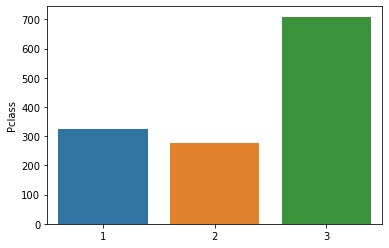

In [111]:
sns.barplot(all_df['Pclass'].value_counts().index,all_df['Pclass'].value_counts())

In [112]:
pd.pivot_table(train_df, index='Survived', columns='Pclass',aggfunc='count',values='Age')
#Pclass has no empty values and it impacts 'Survived' so we can leave it as it is

Pclass,1,2,3
Survived,,,
0,64,90,270
1,122,83,85


## Name
1. We can assume that Name dose not have direct impact on survival
2. What about titles?


In [113]:
all_df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [114]:
all_df['name_title'] = all_df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_df['name_title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
the Countess      1
Dona              1
Don               1
Mme               1
Sir               1
Jonkheer          1
Lady              1
Capt              1
Name: name_title, dtype: int64

In [115]:
nobels=['Master','Dr','Rev','Col','Sir','Don','Lady','the Countess']
all_df['Noble'] = all_df.name_title.apply(lambda x: 1 if x in nobels else 0 )
pd.pivot_table(all_df, index='Survived', columns='Noble',aggfunc='count',values='Age')


Noble,0,1
Survived,,
0.0,398,26
1.0,262,28


In [116]:
# In our sample size the nobles have a batter chance of surrvival than the avrage passanger
# we will keep the nobles column but will drop the name coulumn
# also drop name_title as it has a high colinearity with sex due to Miss, Mr
all_df=all_df.drop(columns=['Name','name_title'])

## Age
1. Fill in missing values


In [117]:
all_df.corrwith(all_df['Age'])

PassengerId    0.028814
Survived      -0.077221
Pclass        -0.408106
Age            1.000000
SibSp         -0.243699
Parch         -0.150917
Fare           0.178740
Noble         -0.245267
dtype: float64

In [118]:
#Lets use two most relevant coulumns
all_df.groupby(['Pclass'])['Age'].median()

Pclass
1    39.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [119]:
all_df.groupby(['SibSp'])['Age'].median()

SibSp
0    28.0
1    30.0
2    21.5
3    14.5
4     7.0
5    10.5
8    14.5
Name: Age, dtype: float64

In [120]:
all_df.groupby(['Parch'])['Age'].median()

Parch
0    29.0
1    22.5
2    17.0
3    42.0
4    45.0
5    39.0
6    41.5
9     NaN
Name: Age, dtype: float64

1. If SibSp > 1 we can deduce that a passnager is traveling with at least one sibling, but this effect only really shows on age when SibSp > 2
2. If Parch > 2 we can deduce that the passanger is traveling with children

In [121]:
for i in range(0,len(all_df)):
    x=0
    if pd.isna(all_df.at[i,'Age']):
        if all_df.at[i,'Parch'] > 2:
            x = 10
        elif all_df.at[i,'SibSp'] > 2:
            x = -10
        all_df.at[i,'Age']=all_df.groupby(['Pclass'])['Age'].median()[all_df.at[i,'Pclass']] +x


## Sex


In [122]:
pd.pivot_table(train_df,index='Survived',columns='Sex', values = 'Ticket', aggfunc='count')


Sex,female,male
Survived,,
0,81,468
1,233,109


<AxesSubplot:title={'center':'Sex and Survival'}>

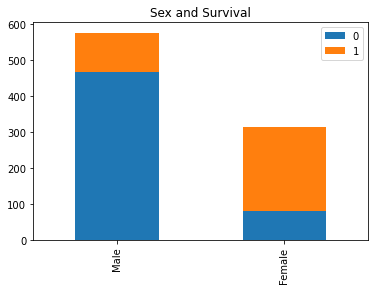

In [123]:
males = train_df[train_df['Sex']=='male']['Survived'].value_counts()
females = train_df[train_df['Sex']=='female']['Survived'].value_counts()
df = pd.DataFrame([males,females])
df.index=['Male','Female']
df.plot(kind='bar',stacked=True,fig=(18,6),title='Sex and Survival')

## SibSp and Parch
1. already used in 'Age'
2. no missing values
3. Can we derive other values based on them?

In [124]:
#Family and Alone
all_df['Family_Size']=all_df['SibSp']+all_df['Parch']+1
all_df['Alone'] = all_df.Family_Size.apply(lambda x: 1 if x==1 else 0 )

print(pd.pivot_table(all_df,index='Survived',columns='Alone',values='Age',aggfunc='count'))
print("##########################################################################")
print(pd.pivot_table(all_df,index='Survived',columns='Family_Size',values='Age',aggfunc='count'))



Alone       0    1
Survived          
0.0       175  374
1.0       179  163
##########################################################################
Family_Size     1     2     3     4     5     6    7    8    11
Survived                                                       
0.0          374.0  72.0  43.0   8.0  12.0  19.0  8.0  6.0  7.0
1.0          163.0  89.0  59.0  21.0   3.0   3.0  4.0  NaN  NaN


# Ticket
1. What can ticket tell us?

In [125]:
all_df["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [126]:
all_df['ticket_num'] = all_df.Ticket.apply(lambda x: x if x.isnumeric() else (x.split(' ')[-1]))
all_df['ticket_lett']=all_df.Ticket.apply(lambda x: 0 if x.isnumeric() else (x.split(' ')[0]) )
all_df.tail(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Noble,Family_Size,Alone,ticket_num,ticket_lett
1299,1300,NaN,3,female,24.0,0,0,334915,7.7208,NaN,Q,0,1,1,334915,0
1300,1301,NaN,3,female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,0,3,0,3101315,SOTON/O.Q.
1301,1302,NaN,3,female,24.0,0,0,365237,7.7500,NaN,Q,0,1,1,365237,0
1302,1303,NaN,1,female,37.0,1,0,19928,90.0000,C78,Q,0,2,0,19928,0
1303,1304,NaN,3,female,28.0,0,0,347086,7.7750,NaN,S,0,1,1,347086,0
1304,1305,NaN,3,male,24.0,0,0,A.5. 3236,8.0500,NaN,S,0,1,1,3236,A.5.
1305,1306,NaN,1,female,39.0,0,0,PC 17758,108.9000,C105,C,0,1,1,17758,PC
1306,1307,NaN,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,1,1,3101262,SOTON/O.Q.
1307,1308,NaN,3,male,24.0,0,0,359309,8.0500,NaN,S,0,1,1,359309,0
1308,1309,NaN,3,male,24.0,1,1,2668,22.3583,NaN,C,1,3,0,2668,0


In [127]:
#Not sure there is much here
all_df=all_df.drop(columns=['Ticket','ticket_num','ticket_lett','PassengerId'])

## Cabin
1. fill missing values
2. What else can it tell us?

In [128]:

all_df['cabin_num'] = all_df.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_df['cabin_lett'] = all_df.Cabin.apply(lambda x: str(x)[0])

print(pd.pivot_table(all_df, index = 'Survived', columns = 'cabin_num', values = 'Age' ,aggfunc ='count'))
print('######################################################################')
print(pd.pivot_table(all_df,index='Survived',columns='cabin_lett', values = 'Age', aggfunc='count'))

cabin_num      0      1    2    3    4
Survived                              
0.0        481.0   58.0  7.0  3.0  NaN
1.0        206.0  122.0  9.0  3.0  2.0
######################################################################
cabin_lett    A     B     C     D     E    F    G    T      n
Survived                                                     
0.0         8.0  12.0  24.0   8.0   8.0  5.0  2.0  1.0  481.0
1.0         7.0  35.0  35.0  25.0  24.0  8.0  2.0  NaN  206.0


In [129]:
all_df.groupby(['cabin_lett'])['Fare'].median()

cabin_lett
A    35.0771
B    82.2667
C    86.2896
D    52.5542
E    53.1000
F    13.0000
G    16.7000
T    35.5000
n    10.5000
Name: Fare, dtype: float64

In [130]:
# Lets use missing values as their own cathegory 
all_df['cabin_num'] = all_df.Cabin.apply(lambda x: 0 if pd.isna(x) else (x.split(' ')[0])[1:])
all_df['cabin_lett'] = all_df.Cabin.apply(lambda x: str(x)[0])
all_df.tail(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Noble,Family_Size,Alone,cabin_num,cabin_lett
1299,NaN,3,female,24.0,0,0,7.7208,NaN,Q,0,1,1,0,n
1300,NaN,3,female,3.0,1,1,13.7750,NaN,S,0,3,0,0,n
1301,NaN,3,female,24.0,0,0,7.7500,NaN,Q,0,1,1,0,n
1302,NaN,1,female,37.0,1,0,90.0000,C78,Q,0,2,0,78,C
1303,NaN,3,female,28.0,0,0,7.7750,NaN,S,0,1,1,0,n
1304,NaN,3,male,24.0,0,0,8.0500,NaN,S,0,1,1,0,n
1305,NaN,1,female,39.0,0,0,108.9000,C105,C,0,1,1,105,C
1306,NaN,3,male,38.5,0,0,7.2500,NaN,S,0,1,1,0,n
1307,NaN,3,male,24.0,0,0,8.0500,NaN,S,0,1,1,0,n
1308,NaN,3,male,24.0,1,1,22.3583,NaN,C,1,3,0,0,n


In [131]:
all_df['Cabin'].value_counts()
# Some passangers have multipe cabins? 
# Dose this affect Survival? Is it corralated with Fare?
for i in range(0,len(all_df)):
    if pd.isna(all_df.at[i,'Cabin']):
        all_df.at[i,'nOf_Cabins']= 0
    else:
        all_df.at[i,'nOf_Cabins']= len(all_df.at[i,'Cabin'].split())
all_df['nOf_Cabins'].value_counts()
print(all_df['nOf_Cabins'].corr(all_df['Fare']))
pd.pivot_table(all_df,index='Survived',columns='nOf_Cabins',values='Age',aggfunc='count')

0.633223677079347


nOf_Cabins,0.0,1.0,2.0,3.0,4.0
Survived,,,,,
0.0,481.0,58.0,7.0,3.0,NaN
1.0,206.0,122.0,9.0,3.0,2.0


In [132]:
#Estimate distance to stairs based on https://www.encyclopedia-titanica.org/titanic-deckplans/
# _Cstairs is a list with cabin numbers colosest to stairs up on each deck
A_Cstairs=[34,35,36,37,3,4]
B_Cstairs=[91,92,46,47,5,6]
C_Cstairs=[102,93,142,123,90,83,95,104,40,39]
D_Cstairs=[61,62,55,56,69,70,35,34]
E_Cstairs=[61,62,55,56,69,70,35,34]
F_Cstairs=[50,54,59,15,18]
G_Cstairs=[16,8,2,18]
#Distance_Calculator returns the distance from each cabin to a cabin closest to the stairs
def Distance_Calculator( c_num , list):
    distances=np.zeros(len(list))
    for j in range(0,len(list)):
        try:
            distances[j]=abs(int(c_num)-list[j])
        except:
            try:
                distances[j]=abs(int(c_num[1:]-list[j]))
            except:
                try:
                    distances[j]=abs(int(c_num[2:]-list[j]))
                except:
                    distances[j]=50
    return(min(distances))

In [133]:
for i in range(0,len(all_df)):
    if all_df.at[i,'cabin_lett']=='n':
        all_df.at[i,'Distance']= 50
    elif all_df.at[i,'cabin_lett']=='A':
        all_df.at[i,'Distance']= Distance_Calculator(all_df.at[i,'cabin_num'], A_Cstairs)
    elif all_df.at[i,'cabin_lett']=='B ':
        train_df.at[i,'Distance']= Distance_Calculator(all_df.at[i,'cabin_num'], B_Cstairs)
    elif all_df.at[i,'cabin_lett']=='C':
        all_df.at[i,'Distance']= Distance_Calculator(all_df.at[i,'cabin_num'], C_Cstairs)
    elif all_df.at[i,'cabin_lett']=='D':
        all_df.at[i,'Distance']= Distance_Calculator(all_df.at[i,'cabin_num'], D_Cstairs)
    elif all_df.at[i,'cabin_lett']=='E':
        all_df.at[i,'Distance']= Distance_Calculator(all_df.at[i,'cabin_num'], E_Cstairs)
    elif all_df.at[i,'cabin_lett']=='F':
        all_df.at[i,'Distance']= Distance_Calculator(all_df.at[i,'cabin_num'], F_Cstairs)
    elif all_df.at[i,'cabin_lett']=='G':
        all_df.at[i,'Distance']= Distance_Calculator(all_df.at[i,'cabin_num'], G_Cstairs)
    else:
        all_df.at[i,'Distance']= 50

In [134]:
all_df['Distance'].fillna(50)
all_df['Distance'].corr(all_df['Survived'])

-0.22731871047912852

In [135]:
all_df=all_df.drop(columns='Cabin')

## Embarked two missing values

In [136]:
all_df['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [137]:
all_df['Embarked']=all_df['Embarked'].fillna('S')

## Fare
1. One value missing

In [138]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    float64
 1   Pclass       1309 non-null   int64  
 2   Sex          1309 non-null   object 
 3   Age          1309 non-null   float64
 4   SibSp        1309 non-null   int64  
 5   Parch        1309 non-null   int64  
 6   Fare         1308 non-null   float64
 7   Embarked     1309 non-null   object 
 8   Noble        1309 non-null   int64  
 9   Family_Size  1309 non-null   int64  
 10  Alone        1309 non-null   int64  
 11  cabin_num    1309 non-null   object 
 12  cabin_lett   1309 non-null   object 
 13  nOf_Cabins   1309 non-null   float64
 14  Distance     1309 non-null   float64
dtypes: float64(5), int64(6), object(4)
memory usage: 153.5+ KB


# Fare
1. One missing value

In [139]:
for i in range(0,len(all_df)):
    if pd.isna(all_df.at[i,'Fare']):
        print(all_df.iloc[i])
    else:
        pass

Survived        NaN
Pclass            3
Sex            male
Age            60.5
SibSp             0
Parch             0
Fare            NaN
Embarked          S
Noble             0
Family_Size       1
Alone             1
cabin_num         0
cabin_lett        n
nOf_Cabins      0.0
Distance       50.0
Name: 1043, dtype: object


In [140]:
#Given its a Pclass =3
all_df['Fare'] = all_df['Fare'].fillna(all_df.groupby(['Pclass'])['Fare'].mean()[3])

In [141]:
all_df=all_df.drop(columns='cabin_num')
all_df.info()
# no missing values, can prepear for fitting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    float64
 1   Pclass       1309 non-null   int64  
 2   Sex          1309 non-null   object 
 3   Age          1309 non-null   float64
 4   SibSp        1309 non-null   int64  
 5   Parch        1309 non-null   int64  
 6   Fare         1309 non-null   float64
 7   Embarked     1309 non-null   object 
 8   Noble        1309 non-null   int64  
 9   Family_Size  1309 non-null   int64  
 10  Alone        1309 non-null   int64  
 11  cabin_lett   1309 non-null   object 
 12  nOf_Cabins   1309 non-null   float64
 13  Distance     1309 non-null   float64
dtypes: float64(5), int64(6), object(3)
memory usage: 143.3+ KB


In [142]:
## Preapear data for fitting

In [143]:
#Create dummies
dummies = pd.get_dummies(all_df[['Pclass','Sex','Embarked','cabin_lett',]])
final_data=dummies.join([all_df['Survived'],all_df['Age'],all_df['SibSp'],all_df['Parch'],all_df['Fare'],all_df['Noble'],all_df['Family_Size'],all_df['nOf_Cabins'],all_df['Distance']])


In [144]:
#Scale data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
final_scaled= final_data.copy()
final_scaled[['Age','SibSp','Parch','Fare','Family_Size','nOf_Cabins','Distance']]= scale.fit_transform(final_scaled[['Age','SibSp','Parch','Fare','Family_Size','nOf_Cabins','Distance']])

In [145]:
#Split into train and test
train = final_scaled[0:891]
test = final_scaled[891:]
X=train.drop(columns='Survived')
Y=train.Survived

In [146]:
#Create train and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,Y,test_size=0.2)

# Model selection

In [147]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 

In [148]:
lr = LogisticRegression(max_iter = 2000)
lr.fit(x_train,y_train)
yhat=lr.predict(x_val)
acc=accuracy_score
acc(yhat,y_val)
cv = cross_val_score(lr,x_train,y_train,cv=10)
print(cv)
print('Mean cv score = ', cv.mean())
print("Validation accuracy = ",acc(yhat,y_val))

[0.80555556 0.84722222 0.77464789 0.88732394 0.85915493 0.90140845
 0.87323944 0.69014085 0.88732394 0.74647887]
Mean cv score =  0.8272496087636932
Validation accuracy =  0.7988826815642458


In [149]:
rmf=RandomForestClassifier(random_state=1)
rmf.fit(x_train,y_train)
yhat=rmf.predict(x_val)
acc=accuracy_score
acc(yhat,y_val)
cv = cross_val_score(rmf,x_train,y_train,cv=10)
print(cv)
print('Mean cv score = ', cv.mean())
print("Validation accuracy = ",acc(yhat,y_val))

[0.77777778 0.83333333 0.74647887 0.83098592 0.90140845 0.88732394
 0.83098592 0.73239437 0.77464789 0.73239437]
Mean cv score =  0.804773082942097
Validation accuracy =  0.8212290502793296


In [150]:
svc=SVC()
svc.fit(x_train,y_train)
yhat=svc.predict(x_val)
acc=accuracy_score
acc(yhat,y_val)
cv = cross_val_score(svc,x_train,y_train,cv=10)
print(cv)
print('Mean cv score = ', cv.mean())
print("Validation accuracy = ",acc(yhat,y_val))

[0.76388889 0.86111111 0.78873239 0.87323944 0.87323944 0.91549296
 0.85915493 0.74647887 0.84507042 0.71830986]
Mean cv score =  0.8244718309859154
Validation accuracy =  0.8268156424581006


In [151]:

xgb=XGBClassifier(use_label_encoder=False, eval_metric='error')
xgb.fit(x_train,y_train)
yhat=xgb.predict(x_val)
acc=accuracy_score
acc(yhat,y_val)
cv = cross_val_score(xgb,x_train,y_train,cv=10)
print(cv)
print('Mean cv score = ', cv.mean())
print("Validation accuracy = ",acc(yhat,y_val))

[0.80555556 0.81944444 0.81690141 0.81690141 0.88732394 0.84507042
 0.81690141 0.69014085 0.78873239 0.76056338]
Mean cv score =  0.8047535211267606
Validation accuracy =  0.8212290502793296


# Parameter tuning
## LogisticRegression , RandomForest, XGBClassifier and SVC preform similarly

In [152]:
# Logistic regression 
parameters = {'penalty':['l2'], 'C':[0.1, 1, 10], 'solver':['lbfgs', 'liblinear']}
lr=LogisticRegression(max_iter = 2000)
clf = GridSearchCV(lr, parameters)
clf.fit(x_train,y_train)
clf.best_params_
yhat=clf.predict(x_val)
print(clf.best_params_)
print("Validation accuracy = ",acc(yhat,y_val))

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation accuracy =  0.7988826815642458


In [153]:
# Random Forest
parameters = {'criterion':['gini','entropy'], 'min_samples_split':[2,3,4],'min_samples_leaf':[1,2,3]}

rmf=RandomForestClassifier()
clf = GridSearchCV(rmf, parameters)
clf.fit(x_train,y_train)
clf.best_params_
yhat=clf.predict(x_val)
print(clf.best_params_)
print("Validation accuracy = ",acc(yhat,y_val))

{'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 4}
Validation accuracy =  0.8156424581005587


In [154]:
# SVM
parameters = {'kernel':['linear','poly','rbf'], 'C':[0.1, 1], 'degree':[2,3,4],'gamma':[0.1,1]}

svc=SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(x_train,y_train)
clf.best_params_
yhat=clf.predict(x_val)
print(clf.best_params_)
print("Validation accuracy = ",acc(yhat,y_val))

{'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
Validation accuracy =  0.8324022346368715


# Making submisions

In [ ]:
test=test.drop(columns='Survived')

In [170]:
lr=LogisticRegression(max_iter = 2000,C= 0.1, penalty='l2', solver= 'lbfgs')
lr.fit(X,Y)
yhat=lr.predict(test)
submition_lr=pd.DataFrame()
submition_lr['PassengerId']=test_df['PassengerId']
submition_lr['Survived']=yhat




In [171]:
rmf=RandomForestClassifier(criterion='gini', min_samples_leaf= 3, min_samples_split= 4)
rmf.fit(X,Y)
yhat=rmf.predict(test)
submition_rmf=pd.DataFrame()
submition_rmf['PassengerId']=test_df['PassengerId']
submition_rmf['Survived']=yhat

In [172]:
svc=SVC(C= 0.1, degree= 2,kernel= 'poly')
svc.fit(X,Y)
yhat=svc.predict(test)
submition_svc=pd.DataFrame()
submition_svc['PassengerId']=test_df['PassengerId']
submition_svc['Survived']=yhat